In [2]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [1]:
import pandas as pd
import numpy as np
snapshots_hist = pd.read_csv('/content/drive/MyDrive/New_Snapshots/snapshots_hist.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/New_Snapshots/snapshots_hist.csv'

In [ ]:
# prompt: give me code that list all the columns and the number of unique values in those columns?

for col in snapshots_hist.columns:
  print(f'{col}: {snapshots_hist[col].nunique()}')

center_id: 62
days_since_join: 996
total_events: 5901
total_quizzes: 5901
days_since_last_event: 30
days_since_last_quiz: 476
sum_component_time: 46137
avg_component_time: 95295
pct_completed: 24149
n_unique_components: 80
mean_gap: 19052
max_gap: 30
num_sessions: 15
pct_weekend_events: 29217
activity_trend: 70911
n_unique_topics: 32
topic_entropy: 86224
n_unique_chapters: 69
chapter_entropy: 91728
component_entropy: 93001
n_courses: 2
label: 2
snapshot_date: 49
batch_id_te: 546
batch_dropout_rate_hist: 1737
batch_avg_events_hist: 70321


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import display

# Assume snapshots_hist is already loaded

# 1. Create derived features to aggregate collinear ones
obs_window_days = 30

# Events per component (collinear with total_events & n_unique_components)
snapshots_hist['events_per_component'] = (
    snapshots_hist['total_events'] /
    snapshots_hist['n_unique_components'].replace(0, np.nan)
)

# Events per day (collinear with total_events)
snapshots_hist['events_per_day'] = snapshots_hist['total_events'] / obs_window_days

# Engagement intensity (e.g., average time per event)
snapshots_hist['engagement_intensity'] = (
    snapshots_hist['sum_component_time'] /
    snapshots_hist['total_events'].replace(0, np.nan)
)

# Breadth score (duplicate of n_unique_components)
snapshots_hist['breadth_score'] = snapshots_hist['n_unique_components']

# Activity density: combines frequency & intensity relative to gaps
snapshots_hist['activity_density'] = (
    snapshots_hist['events_per_day'] *
    snapshots_hist['engagement_intensity'] /
    (snapshots_hist['mean_gap'] + 1)
)

# 2. Drop highly collinear raw features
to_drop = [
    'total_quizzes',
    'events_per_component',
    'breadth_score',
    'n_unique_components',
    'events_per_day',
    'engagement_intensity'
]
reduced_df = snapshots_hist.drop(columns=to_drop)

# 3. Compute VIF on remaining numeric predictors
# Exclude non-numeric and label
num_df = reduced_df.select_dtypes(include=[np.number]).drop(columns=['label'])

vif_data = pd.DataFrame({
    'feature': num_df.columns,
    'VIF': [
        variance_inflation_factor(num_df.values, idx)
        for idx in range(num_df.shape[1])
    ]
})

display(vif_data)

,feature,VIF
0,center_id,649.159338
1,days_since_join,2.349930
2,total_events,9.683600
3,days_since_last_event,4.984375
4,days_since_last_quiz,1.858836
5,sum_component_time,139078.124111
6,avg_component_time,5.781353
7,pct_completed,12.121279
8,mean_gap,1.454876
9,max_gap,4.611405


In [ ]:
high_vif = [
    'center_id',
    'sum_component_time',
    'pct_completed',
    'n_unique_topics',
    'topic_entropy',
    'n_unique_chapters',
    'chapter_entropy',
    'component_entropy',
    'n_courses',
    'activity_density'
]

# Drop the high-VIF columns
clean_df = reduced_df.drop(columns=high_vif)

# Recompute VIF to confirm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

num_df = clean_df.select_dtypes(include=[np.number]).drop(columns=['label'])
vif_df = pd.DataFrame({
    'feature': num_df.columns,
    'VIF': [variance_inflation_factor(num_df.values, i) for i in range(num_df.shape[1])]
})
print(vif_df)


                    feature        VIF
0           days_since_join   2.141224
1              total_events   1.272157
2     days_since_last_event   4.086294
3      days_since_last_quiz   1.761865
4        avg_component_time   3.657173
5                  mean_gap   1.252095
6                   max_gap   2.570570
7              num_sessions   2.582386
8        pct_weekend_events   1.598029
9            activity_trend   1.010599
10              batch_id_te  12.283129
11  batch_dropout_rate_hist   5.343738
12    batch_avg_events_hist   1.490217


In [ ]:
c

,feature,VIF
0,days_since_join,2.141224
1,total_events,1.272157
2,days_since_last_event,4.086294
3,days_since_last_quiz,1.761865
4,avg_component_time,3.657173
5,mean_gap,1.252095
6,max_gap,2.570570
7,num_sessions,2.582386
8,pct_weekend_events,1.598029
9,activity_trend,1.010599


In [ ]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import lightgbm as lgb

# 1) Make sure your dates are datetimes
reduced_df['snapshot_date'] = pd.to_datetime(
    reduced_df['snapshot_date'],
    errors='coerce'
)


# 2. Split by time
cutoff = reduced_df['snapshot_date'].quantile(0.8)
train_df = reduced_df[reduced_df['snapshot_date'] <= cutoff].copy()
test_df  = reduced_df[reduced_df['snapshot_date'] >  cutoff].copy()

# 3. Define features & drop columns LightGBM can't handle
drop_cols = [
    'user_id', 'snapshot_date', 'user_joining_date', 'label', 'batch_id','batch_dropout_rate','batch_avg_events'
]
feature_cols = [c for c in reduced_df.columns if c not in drop_cols]

X_train = pd.get_dummies(train_df[feature_cols], drop_first=True)
y_train = train_df['label']
X_test  = pd.get_dummies(test_df[feature_cols], drop_first=True)
y_test  = test_df['label']

# align columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# 4. Train
model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. Evaluate
y_prob = model.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_prob)
prec, rec, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(rec, prec)
print(f'ROC AUC: {roc_auc:.4f}  |  PR AUC: {pr_auc:.4f}')

# 6. Top features
importances = pd.Series(model.feature_importances_, index=X_train.columns)
print(importances.sort_values(ascending=False).head(20))


[LightGBM] [Info] Number of positive: 66236, number of negative: 47512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4285
[LightGBM] [Info] Number of data points in the train set: 113748, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.582305 -> initscore=0.332242
[LightGBM] [Info] Start training from score 0.332242
ROC AUC: 0.8626  |  PR AUC: 0.8796
batch_id_te                483
days_since_join            425
batch_dropout_rate_hist    318
days_since_last_quiz       244
days_since_last_event      193
batch_avg_events_hist      155
topic_entropy              138
center_id                  135
pct_completed               92
activity_trend              87
chapter_entropy             80
total_events                76
sum_component_time          72
avg_c

MLP Test ROC AUC: 0.8582
MLP Test PR  AUC: 0.8760


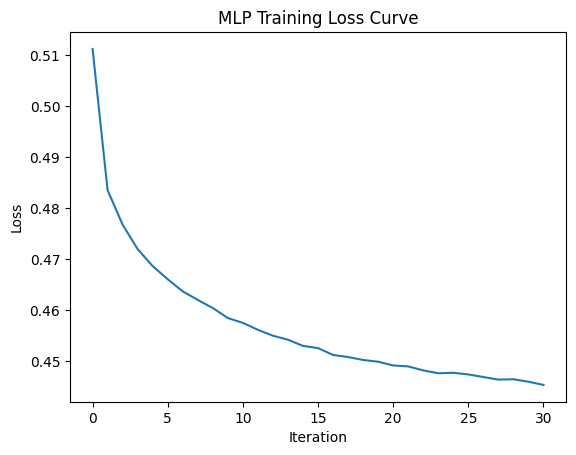

In [ ]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

# 1. Load data and split by time

cutoff = clean_df['snapshot_date'].quantile(0.8)
train_df = clean_df[clean_df['snapshot_date'] <= cutoff].copy()
test_df  = clean_df[clean_df['snapshot_date'] >  cutoff].copy()

# 2. Prepare feature matrix and labels (drop non-features)
drop_cols = [
    'user_id', 'snapshot_date', 'user_joining_date', 'label',
    'batch_id', 'batch_dropout_rate', 'batch_avg_events'
]
feature_cols = [c for c in clean_df.columns if c not in drop_cols]

X_train = pd.get_dummies(train_df[feature_cols], drop_first=True)
y_train = train_df['label']
X_test  = pd.get_dummies(test_df[feature_cols], drop_first=True)
y_test  = test_df['label']
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# 3. Build pipeline: scaling + MLP
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        early_stopping=True,
        validation_fraction=0.1,
        alpha=0.001,
        max_iter=200,
        random_state=42
    ))
])

# 4. Train
pipeline.fit(X_train, y_train)

# 5. Predict and evaluate
y_prob_mlp = pipeline.predict_proba(X_test)[:, 1]
roc_auc_mlp = roc_auc_score(y_test, y_prob_mlp)
prec_mlp, rec_mlp, _ = precision_recall_curve(y_test, y_prob_mlp)
pr_auc_mlp = auc(rec_mlp, prec_mlp)

print(f"MLP Test ROC AUC: {roc_auc_mlp:.4f}")
print(f"MLP Test PR  AUC: {pr_auc_mlp:.4f}")

# 6. (Optional) Display model loss curve
import matplotlib.pyplot as plt
plt.plot(pipeline.named_steps['mlp'].loss_curve_)
plt.title('MLP Training Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Assume `model` is your trained LightGBM classifier,
# and X_test, y_test are your test features and labels.

# 1. Get predicted labels (using 0.5 threshold)
y_pred = model.predict(X_test)

# 2. Calculate precision, recall, and F1 for the positive “dropout” class
precision = precision_score(y_test, y_pred, pos_label=1)
recall    = recall_score   (y_test, y_pred, pos_label=1)
f1        = f1_score       (y_test, y_pred, pos_label=1)

print(f"Dropout class precision: {precision:.4f}")
print(f"Dropout class recall:    {recall:.4f}")
print(f"Dropout class F1-score:  {f1:.4f}")

# 3. (Optional) Full classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Active (0)','Dropped (1)']))


Dropout class precision: 0.8067
Dropout class recall:    0.7757
Dropout class F1-score:  0.7909

Classification Report:

              precision    recall  f1-score   support

  Active (0)       0.74      0.78      0.76     12505
 Dropped (1)       0.81      0.78      0.79     15128

    accuracy                           0.78     27633
   macro avg       0.77      0.78      0.77     27633
weighted avg       0.78      0.78      0.78     27633



In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, classification_report

# Assume you already have:
# - model: your trained LightGBM (or any) classifier
# - X_test: test features
# - y_test: true labels for test set

# 1. Predict raw probabilities for the positive class
y_prob = model.predict_proba(X_test)[:, 1]

# 2. Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# 3. Find threshold that maximizes F1-score
f1_scores = 2 * (precision * recall) / (precision + recall)
best_idx = np.nanargmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Optimal threshold for max F1: {best_threshold:.3f} (F1 = {best_f1:.3f})")

# 4. (Optional) Find threshold for a desired precision level
desired_precision = 0.80
# Only consider thresholds where precision >= desired_precision
valid = np.where(precision[:-1] >= desired_precision)[0]
if valid.size > 0:
    thresh_for_prec = thresholds[valid[0]]
    print(f"Threshold for precision ≥ {desired_precision:.2f}: {thresh_for_prec:.3f}")
else:
    print(f"No threshold achieves precision ≥ {desired_precision:.2f}")

# 5. Apply chosen threshold to get new binary predictions
# You can choose either best_threshold or thresh_for_prec
threshold = best_threshold
y_pred_adj = (y_prob >= threshold).astype(int)

# 6. Evaluate adjusted predictions
prec_adj = precision_score(y_test, y_pred_adj, pos_label=1)
rec_adj  = recall_score   (y_test, y_pred_adj, pos_label=1)
f1_adj   = f1_score       (y_test, y_pred_adj, pos_label=1)
print(f"\nAfter thresholding at {threshold:.3f}:")
print(f"Dropout precision: {prec_adj:.4f}")
print(f"Dropout recall:    {rec_adj:.4f}")
print(f"Dropout F1-score:  {f1_adj:.4f}")

# 7. Full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_adj, target_names=['Active (0)', 'Dropped (1)']))


Optimal threshold for max F1: 0.308 (F1 = 0.807)
Threshold for precision ≥ 0.80: 0.484

After thresholding at 0.308:
Dropout precision: 0.7315
Dropout recall:    0.8997
Dropout F1-score:  0.8069

Classification Report:
              precision    recall  f1-score   support

  Active (0)       0.83      0.60      0.70     12505
 Dropped (1)       0.73      0.90      0.81     15128

    accuracy                           0.76     27633
   macro avg       0.78      0.75      0.75     27633
weighted avg       0.78      0.76      0.76     27633



In [ ]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc


cutoff = clean_df['snapshot_date'].quantile(0.8)
train_df = clean_df[clean_df['snapshot_date'] <= cutoff].copy()
test_df  = clean_df[clean_df['snapshot_date'] >  cutoff].copy()

# 2. Define features & target, drop non-features
drop_cols = [
    'user_id', 'snapshot_date', 'user_joining_date', 'label',
    'batch_id','batch_dropout_rate','batch_avg_events'
]
feature_cols = [c for c in clean_df.columns if c not in drop_cols]

X_train = pd.get_dummies(train_df[feature_cols], drop_first=True)
y_train = train_df['label']
X_test  = pd.get_dummies(test_df[feature_cols], drop_first=True)
y_test  = test_df['label']

# Align test to train features
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# 3. Build a pipeline: scaling + logistic regression with L2 penalty
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        penalty='l2',
        solver='liblinear',
        class_weight='balanced',
        random_state=42,
        max_iter=1000
    ))
])

# 4. Hyperparameter grid for C (inverse regularization strength)
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100]
}

# 5. TimeSeries CV on training data
tscv = TimeSeriesSplit(n_splits=3)

grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=tscv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# 6. Fit and select best
grid.fit(X_train, y_train)
print("Best CV AUC:", grid.best_score_)
print("Best C:", grid.best_params_['clf__C'])

# 7. Evaluate on test set
best_model = grid.best_estimator_
y_prob = best_model.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_prob)
prec, rec, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(rec, prec)
print(f'Test ROC AUC: {roc_auc:.4f} | Test PR AUC: {pr_auc:.4f}')


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best CV AUC: 0.798856348245395
Best C: 0.01
Test ROC AUC: 0.8011 | Test PR AUC: 0.8103


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import pandas as pd

# 1. Initialize RandomForest with balanced class weights
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

# 2. Train on the same X_train, y_train
rf.fit(X_train, y_train)

# 3. Predict probabilities on X_test
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# 4. Compute metrics
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_prob_rf)
pr_auc_rf = auc(rec_rf, prec_rf)

print(f"Random Forest Test ROC AUC: {roc_auc_rf:.4f}")
print(f"Random Forest Test PR  AUC: {pr_auc_rf:.4f}")

# 5. Feature importances
importances_rf = pd.Series(rf.feature_importances_, index=X_train.columns)
top20_rf = importances_rf.sort_values(ascending=False).head(20)

print("\nTop 20 Random Forest feature importances:")
print(top20_rf)

Random Forest Test ROC AUC: 0.8457
Random Forest Test PR  AUC: 0.8605

Top 20 Random Forest feature importances:
batch_id_te                0.131210
days_since_join            0.120373
days_since_last_event      0.119558
days_since_last_quiz       0.098021
batch_dropout_rate_hist    0.077856
batch_avg_events_hist      0.077650
avg_component_time         0.074559
total_events               0.067961
mean_gap                   0.055563
max_gap                    0.054917
activity_trend             0.052488
pct_weekend_events         0.037753
num_sessions               0.032090
dtype: float64
